# ALC Simulations based on Analytical Solutions

### $\Delta_1$ resonance

In [7]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy.constants import pi
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go

from plot_settings import set_demonlab_style

def muon_polarization_time_integrated(magnetic_fields, theta, Pz_0, off_resonance_state_rate, A_iso, D_parallel):
    """
    Calculate the time-integrated muon polarization for a given magnetic field and angle theta.
    """
    gamma_muon = 135.5 # in MHz/T
    inv_muon_lifetime = 0.4551 # in MHz
    osc_relaxation = inv_muon_lifetime + off_resonance_state_rate # in MHz

    def calc_q(theta, D_parallel):
        return 0.75 * D_parallel * np.sin(theta) * np.cos(theta)

    def calc_nu_mu(A_iso, D_parallel, theta):
        return (A_iso + D_parallel/2 * (3 * np.cos(theta)**2 - 1)) / 2

    q = calc_q(theta, D_parallel)
    nu_mu = calc_nu_mu(A_iso, D_parallel, theta)
    nu_mu0 = gamma_muon * magnetic_fields

    nominator = 0.5 * q**2 * Pz_0
    denominators = (osc_relaxation/2/pi)**2 + q**2 + (nu_mu0 - nu_mu)**2

    return 1 - nominator/denominators

In [31]:
magnetic_fields = np.linspace(1.8675, 1.9325, 3000) # in Tesla
thetas = np.radians([1, 5, 20, 45, 70, 85, 89]) # given in degrees and converted to radians
Pz_0 = 1.0
off_resonance_state_rate = 0
A_iso = 514.8 # in MHz
D_parallel = 2 # in MHz

# Parameters for SrTiO3
# magnetic_fields = np.linspace(0, 0.78, 3000) # in Tesla
# thetas = np.radians([1, 5, 20, 45, 70, 85, 89]) # given in degrees and converted to radians
# Pz_0 = 1.0
# off_resonance_state_rate = 0
# A_iso = 1 # in MHz
# D_parallel = 30 # in MHz

df = pd.DataFrame({'B / T': magnetic_fields})
for theta in thetas:
    df[f"θ = {np.degrees(theta):.0f}°"] = muon_polarization_time_integrated(magnetic_fields, theta, Pz_0, off_resonance_state_rate, A_iso, D_parallel)

peak_positions = {
    col: magnetic_fields[np.argmin(df[col].values)]
    for col in df.columns if col != "B / T"
}
print("Peak positions (T):", peak_positions)


# Melt for seaborn plotting
df_melted = df.melt(id_vars="B / T", var_name="θ", value_name="Pz")

# Plot
# plt.figure(figsize=(8,5))
# sns.lineplot(data=df_melted, x="B / T", y="Pz", hue="θ")
# plt.xlabel("B / T")
# plt.ylabel(r"$P_z$")
# plt.legend(title="Angle")

fig = px.line(df_melted, x="B / T", y="Pz", color="θ")
fig.update_layout(height=400, width=600, template='DemonLab', legend=dict(y=0.5, x=1.02, xanchor="left", yanchor="middle"))



Peak positions (T): {'θ = 1°': np.float64(1.9070115038346116), 'θ = 5°': np.float64(1.9069248082694232), 'θ = 20°': np.float64(1.9057110703567857), 'θ = 45°': np.float64(1.9014846615538512), 'θ = 70°': np.float64(1.89723657885962), 'θ = 85°': np.float64(1.8960228409469824), 'θ = 89°': np.float64(1.895936145381794)}


### Numerical integration over $\theta$

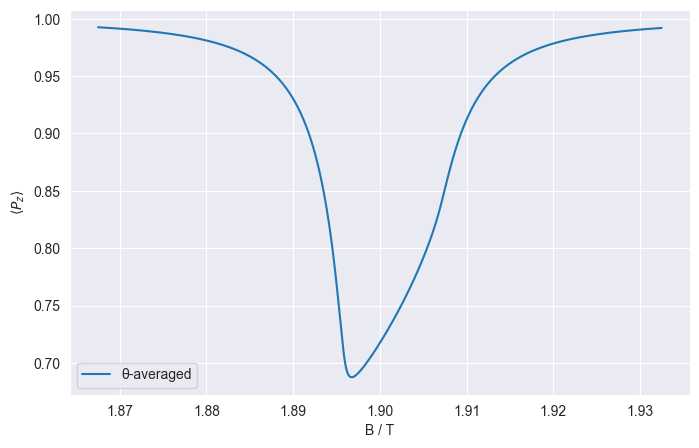

In [3]:
magnetic_fields = np.linspace(1.8675, 1.9325, 3000) # in Tesla
Pz_0 = 1.0
off_resonance_state_rate = 0
A_iso = 514.8 # in MHz
D_parallel = 2 # in MHz

thetas = np.radians(np.linspace(0, 90, 500)) # given in degrees and converted to radians

# compute all polarizations into a 2D array: shape = (len(magnetic_fields), len(thetas))
polarization_matrix = np.column_stack([
    muon_polarization_time_integrated(magnetic_fields, theta, Pz_0, off_resonance_state_rate, A_iso, D_parallel)
    for theta in thetas
])

df = pd.DataFrame(polarization_matrix, columns=[f"θ_{i}" for i in range(len(thetas))])
df.insert(0, "B", magnetic_fields)

# weighted mean across thetas
weights = np.sin(thetas)
polarizations_weighted = np.average(polarization_matrix, axis=1, weights=weights)

df["Pz_avg"] = polarizations_weighted

plt.figure(figsize=(8,5))
plt.plot(df["B"], df["Pz_avg"], label="θ-averaged")
plt.xlabel("B / T")
plt.ylabel(r"$\langle P_z \rangle$")
plt.legend()
plt.show()
